In [45]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from EngbertMicrosaccadeToolbox import microsac_detection

In [46]:
# Set parameters
SAMPLING = 500
MINDUR = 3
VFAC = 5

## Read raw data (ASCII; subject 01, trial 005)

In [47]:
d = pd.read_csv("data/f01.005.dat", sep="\t", header=None, names=["t", "x_l", "y_l", "x_r", "y_r"])
d.head()
d = d.loc[3000:4499]
d.head()

,t,x_l,y_l,x_r,y_r
3000,6000.0,0.01188,0.60588,-0.21384,0.41976
3001,6002.0,0.02376,0.61380,-0.20988,0.41580
3002,6004.0,0.02772,0.62172,-0.19800,0.41976
3003,6006.0,0.03564,0.71280,-0.20196,0.41184
3004,6008.0,0.06336,0.64152,-0.20196,0.42372


In [48]:
right_eye = np.vstack([np.asarray(d.x_r), np.asarray(d.y_r)]).T
left_eye = np.vstack([np.asarray(d.x_l), np.asarray(d.y_l)]).T


## Detect

In [49]:
ms_r, rad_r = microsac_detection.microsacc(right_eye)
ms_l, rad_l = microsac_detection.microsacc(left_eye)

In [50]:
bino, monol, monor = microsac_detection.binsacc(ms_r, ms_l)

In [52]:
len(bino)

4

## Turn into Pandas table

In [7]:
bino = pd.DataFrame(bino, columns=["onset_l", "end_l", "peakvelocity_l", "horizontalcomponent_l", "verticalcomponent_l","horizontalamplitude_l", "verticalamplitude_l", "onset_r", "end_r", "peakvelocity_r", "horizontalcomponent_r", "verticalcomponent_r","horizontalamplitude_r", "verticalamplitude_r"])

## Make the ms-level table contain some saccade information

In [8]:
d = d.reset_index(drop=True).reset_index(names=["t_real"])
d

,t_real,t,x_l,y_l,x_r,y_r
0,0,6000.0,0.01188,0.60588,-0.21384,0.41976
1,1,6002.0,0.02376,0.61380,-0.20988,0.41580
2,2,6004.0,0.02772,0.62172,-0.19800,0.41976
3,3,6006.0,0.03564,0.71280,-0.20196,0.41184
4,4,6008.0,0.06336,0.64152,-0.20196,0.42372
...,...,...,...,...,...,...
1495,1495,8990.0,-0.05148,0.28512,-0.07920,-0.05148
1496,1496,8992.0,-0.04752,0.28908,-0.06336,-0.04356
1497,1497,8994.0,-0.07524,0.29700,-0.07524,-0.04752
1498,1498,8996.0,-0.05544,0.29700,-0.08316,-0.03960


In [9]:
a = microsac_detection.smoothdata(right_eye)
d["xrs"],d["yrs"] = a[:,0], a[:,1]
a = microsac_detection.smoothdata(left_eye)
d["xls"],d["yls"] = a[:,0], a[:,1]


In [10]:
d["sac"] = 0
for idx, row in bino.iterrows():
  d.loc[(d["t_real"]>=row["onset_l"]) & (d["t_real"]<=row["end_l"]), "sac"] = 1

## Plot Saccade data

Text(0.5, 1.0, 'Right Eye')

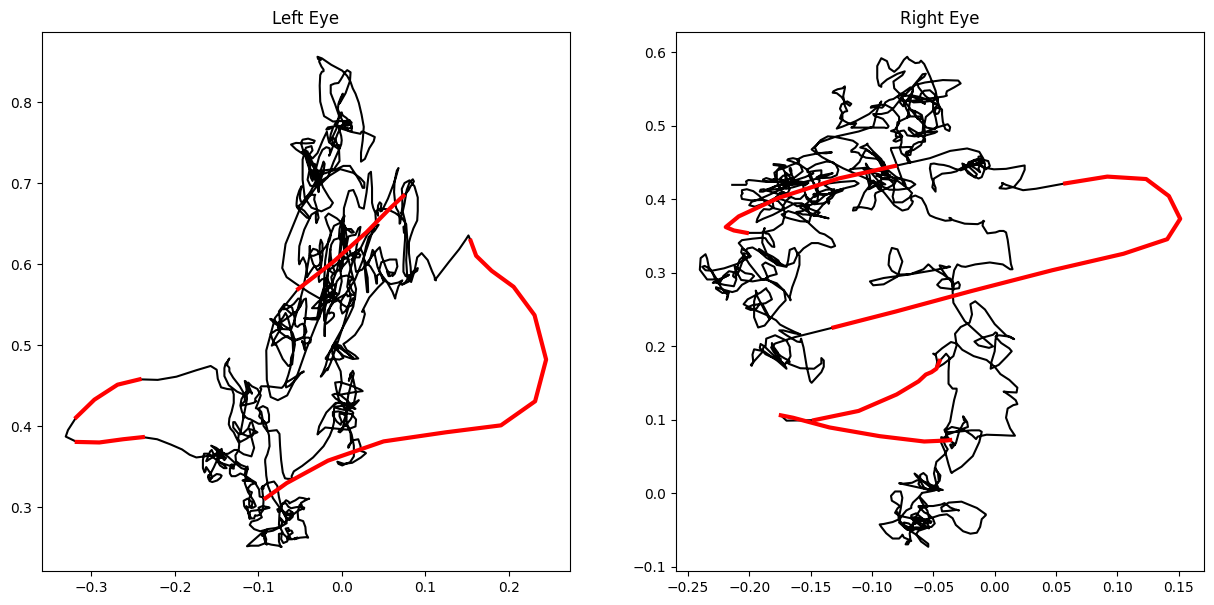

In [11]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(d.xls, d.yls, c="black")
for idx, row in bino.iterrows():
  temp = d.loc[(d["t_real"]>=row["onset_l"]) & (d["t_real"]<=row["end_l"])]
  ax[0].plot(temp.xls, temp.yls, c="red", linewidth=3)
ax[0].set_title("Left Eye")
  
ax[1].plot(d.xrs, d.yrs, c="black")
for idx, row in bino.iterrows():
  temp = d.loc[(d["t_real"]>=row["onset_r"]) & (d["t_real"]<=row["end_r"])]
  ax[1].plot(temp.xrs, temp.yrs, c="red", linewidth=3)
ax[1].set_title("Right Eye")

## Prepare data for velocity space

In [12]:
a = microsac_detection.vecvel(left_eye, 500)
d["v_xl"],d["v_yl"] = a[:,0], a[:,1]

In [13]:
phi = np.linspace(0,2*np.pi, 300)
cx = rad_l[0]*np.cos(phi)
cy = rad_l[1]*np.sin(phi)
#lines(cx,cy,lty=2)

## Plot

Text(0.5, 1.0, 'Velocity')

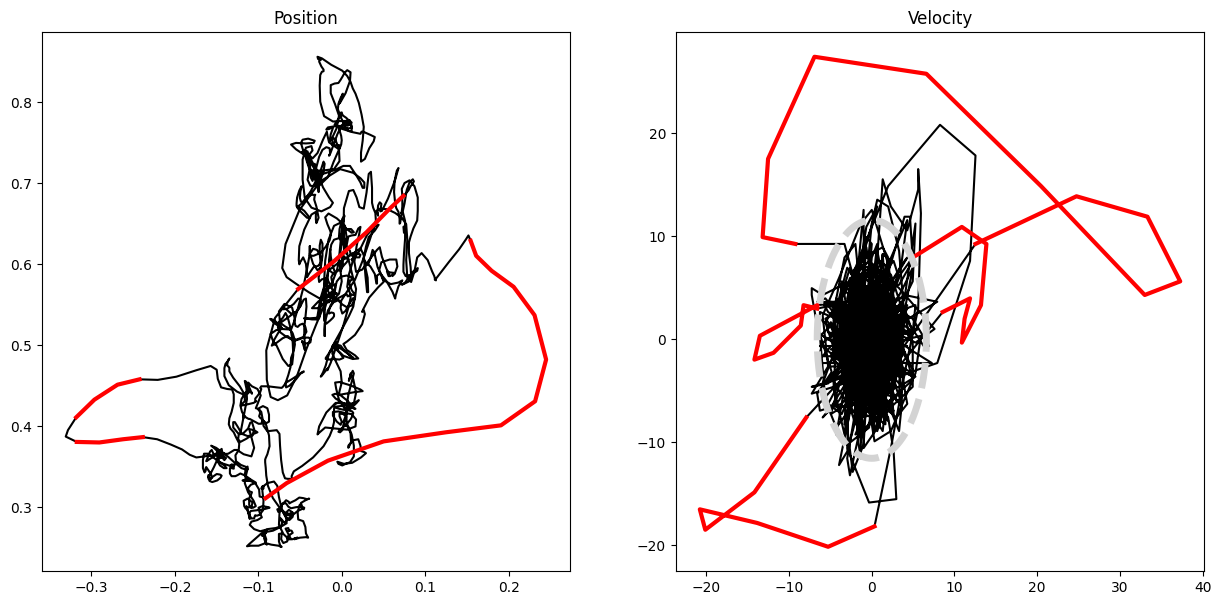

In [14]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(d.xls, d.yls, c="black")
for idx, row in bino.iterrows():
  temp = d.loc[(d["t_real"]>=row["onset_l"]) & (d["t_real"]<=row["end_l"])]
  ax[0].plot(temp.xls, temp.yls, c="red", linewidth=3)
ax[0].set_title("Position")
  
ax[1].plot(d.v_xl, d.v_yl, c="black")
for idx, row in bino.iterrows():
  temp = d.loc[(d["t_real"]>=row["onset_r"]) & (d["t_real"]<=row["end_r"])]
  ax[1].plot(temp.v_xl, temp.v_yl, c="red", linewidth=3)
  
ax[1].plot(cx, cy, c="lightgrey", linestyle="dashed", linewidth=5)
ax[1].set_title("Velocity")

In [15]:
fig.savefig("fig1.png")

# Run Detection for a bunch of Trials

In [16]:
all_list = []
for subj in range(1,6):
  for trial in range(1,6):
    d = pd.read_csv(f"data/f0{subj}.00{trial}.dat", sep="\t", header=None, names=["t", "x_l", "y_l", "x_r", "y_r"])
    right_eye = np.vstack([np.asarray(d.x_r), np.asarray(d.y_r)]).T
    left_eye = np.vstack([np.asarray(d.x_l), np.asarray(d.y_l)]).T
    
    ms_r, rad_r = microsac_detection.microsacc(right_eye)
    ms_l, rad_l = microsac_detection.microsacc(left_eye)
    bino, monol, monor = microsac_detection.binsacc(ms_r, ms_l)
    bino = pd.DataFrame(bino, columns=["onset_l", "end_l", "peakvelocity_l", "horizontalcomponent_l", "verticalcomponent_l","horizontalamplitude_l", "verticalamplitude_l", "onset_r", "end_r", "peakvelocity_r", "horizontalcomponent_r", "verticalcomponent_r","horizontalamplitude_r", "verticalamplitude_r"])
    bino["subj"] = subj
    all_list.append(bino)
    

In [17]:
all_df = pd.concat(all_list, axis=0, ignore_index=True)

In [18]:
all_df["peakvel"] = (all_df["peakvelocity_l"] + all_df["peakvelocity_r"])/2
all_df["ampl"] = (np.sqrt(all_df["horizontalamplitude_l"]**2 + all_df["verticalamplitude_l"]**2) + np.sqrt(all_df["horizontalamplitude_r"]**2 + all_df["verticalamplitude_r"]**2))/2

Text(0, 0.5, 'Peak velocity [deg/s]')

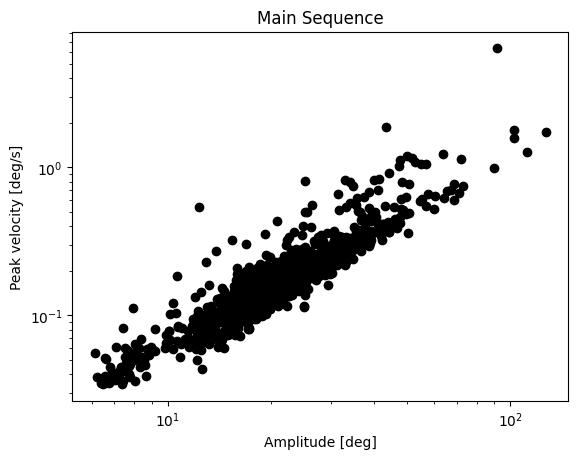

In [19]:
fig, ax = plt.subplots(1,1)
ax.scatter(all_df.peakvel, all_df.ampl, c="black")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Main Sequence")
ax.set_xlabel("Amplitude [deg]")
ax.set_ylabel("Peak velocity [deg/s]")


In [20]:
all_df_l = all_df.copy()
all_df_l.peakvel = all_df.peakvel**10
all_df_l.ampl = all_df.ampl**10

In [21]:
from scipy.optimize import curve_fit
y = all_df.ampl
x = all_df.peakvel

newX = np.logspace(0.8, 2, base=10)
# Let's fit an exponential function.  
# This looks like a line on a lof-log plot.
def myExpFunc(x, a, b):
    return a * np.power(x, b)
popt, pcov = curve_fit(myExpFunc, x, y)

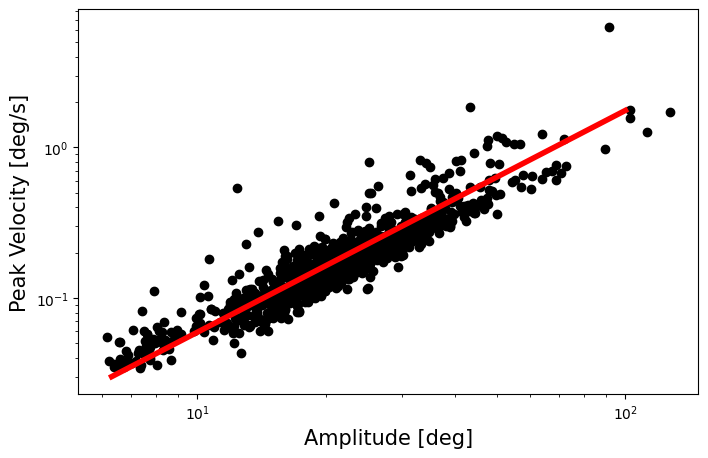

In [22]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.scatter(all_df.peakvel, all_df.ampl, c="black")
#sns.regplot(data=all_df_l, x="peakvel", y="ampl", ax = ax)
ax.plot(newX, myExpFunc(newX, *popt), color='red', lw=4) 
#plt.plot(newX, myExpFunc(newX, *popt), 'r-', 
#         label="({0:.3f}*x**{1:.3f})".format(*popt))
# add reg line
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_title("Main Sequence")
ax.set_xlabel("Amplitude [deg]", fontsize=15)
ax.set_ylabel("Peak Velocity [deg/s]", fontsize=15)
fig.savefig("mainseq.pdf")

Text(0, 0.5, 'Peak velocity [deg/s]')

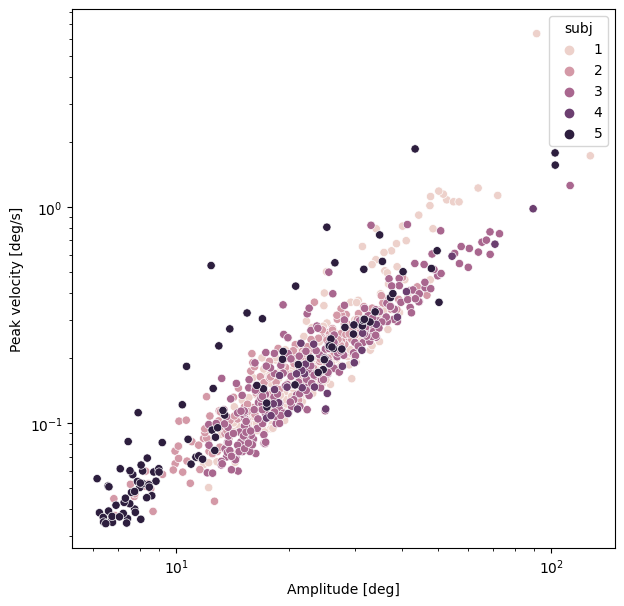

In [23]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(data=all_df, x="peakvel", y="ampl", hue="subj", ax=ax)
ax.set_xlabel("Amplitude [deg]")
ax.set_ylabel("Peak velocity [deg/s]")

# Compare surrogate Data

In [3]:
from EngbertMicrosaccadeToolbox import data_simulation

In [4]:
d = pd.read_csv("data/f01.005.dat", sep="\t", header=None, names=["t", "x_l", "y_l", "x_r", "y_r"])
d.head()
d = d.loc[3000:4499]
d.head()

,t,x_l,y_l,x_r,y_r
3000,6000.0,0.01188,0.60588,-0.21384,0.41976
3001,6002.0,0.02376,0.61380,-0.20988,0.41580
3002,6004.0,0.02772,0.62172,-0.19800,0.41976
3003,6006.0,0.03564,0.71280,-0.20196,0.41184
3004,6008.0,0.06336,0.64152,-0.20196,0.42372


In [5]:
right_eye = np.vstack([np.asarray(d.x_r), np.asarray(d.y_r)]).T
left_eye = np.vstack([np.asarray(d.x_l), np.asarray(d.y_l)]).T


In [6]:
r_eye_s = microsac_detection.smoothdata(right_eye)
d["xrs"], d["yrs"] = r_eye_s[:,0], r_eye_s[:,1]
l_eye_s = microsac_detection.smoothdata(left_eye)
d["xls"], d["yls"] = l_eye_s[:,0], l_eye_s[:,1]
d.head()

,t,x_l,y_l,x_r,y_r,xrs,yrs,xls,yls
3000,6000.0,0.01188,0.60588,-0.21384,0.41976,-0.21384,0.41976,0.01188,0.60588
3001,6002.0,0.02376,0.61380,-0.20988,0.41580,-0.20592,0.41976,0.01980,0.61380
3002,6004.0,0.02772,0.62172,-0.19800,0.41976,-0.20262,0.41976,0.03036,0.63624
3003,6006.0,0.03564,0.71280,-0.20196,0.41184,-0.20196,0.42174,0.04026,0.64746
3004,6008.0,0.06336,0.64152,-0.20196,0.42372,-0.20262,0.42438,0.04422,0.64878


In [15]:
xlsur =  data_simulation.surrogate(l_eye_s, SAMPLING)
#d["x_lsur"], d["y_lsur"] = xlsur[:,0], xlsur[:,1]

Text(0.5, 1.0, 'Surrogate Data')

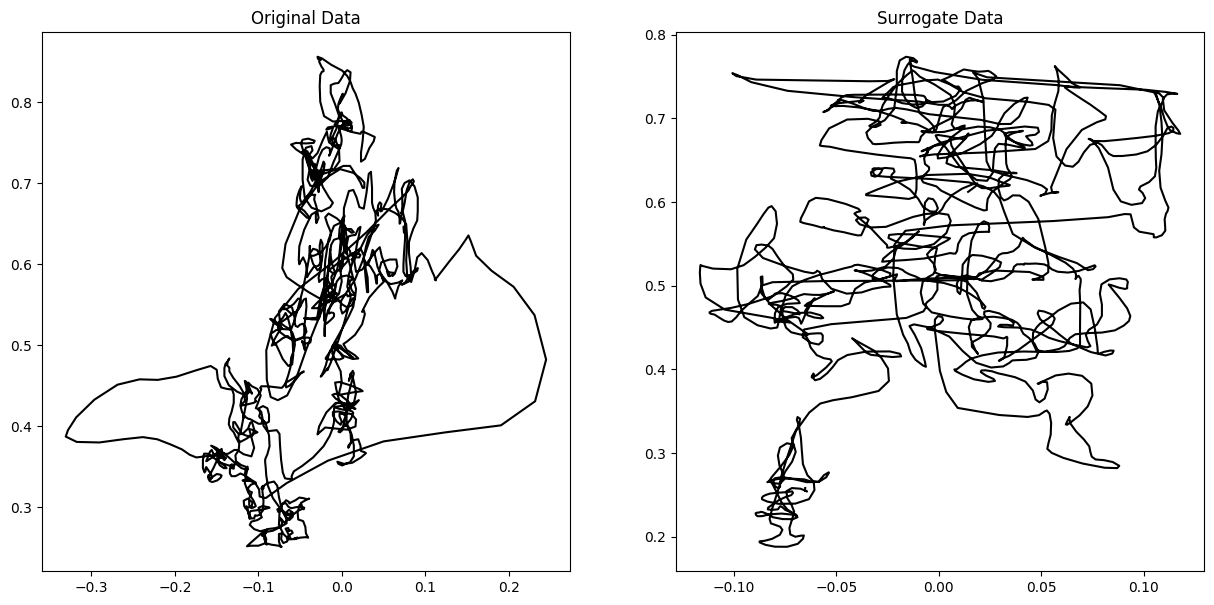

In [18]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(d.xls, d.yls, c="black")
ax[0].set_title("Original Data")
ax[1].plot(xlsur[:,0], xlsur[:,1], c="black")
ax[1].set_title("Surrogate Data")

## Autocorrelation

In [20]:
from statsmodels.tsa.stattools import acf, pacf

In [34]:
surrogate_trajectories = []
for i in range(20):
  surrogate_trajectories.append(data_simulation.surrogate(l_eye_s, SAMPLING))

Text(0, 0.5, 'Lag')

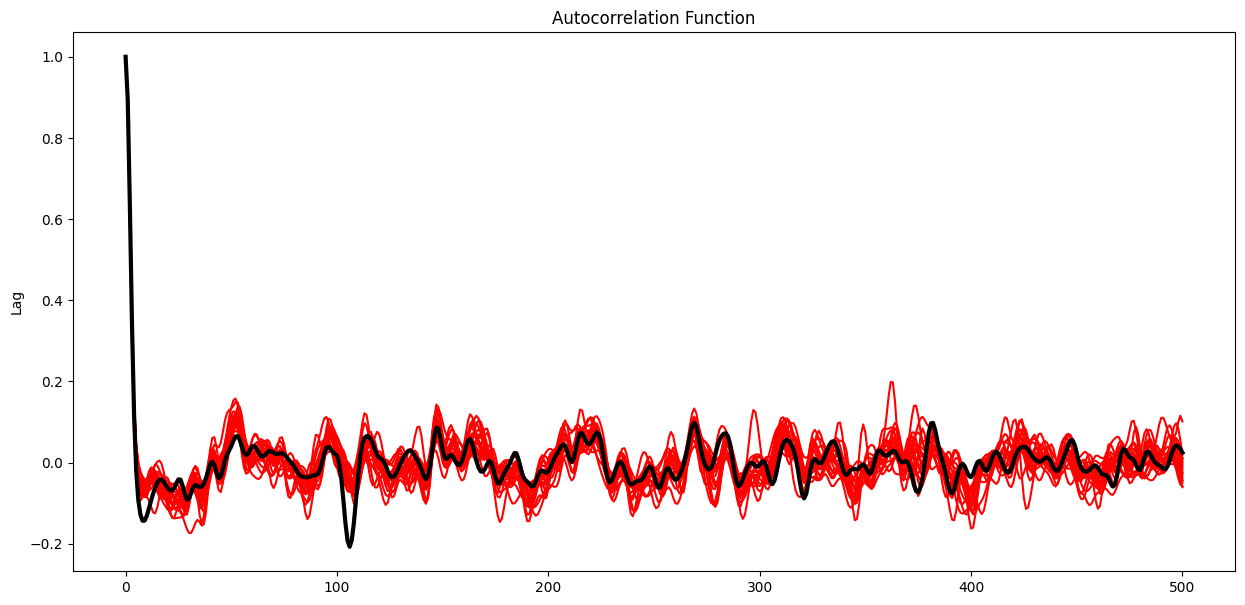

In [41]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
for surrdat in surrogate_trajectories:
  vls = microsac_detection.vecvel(surrdat, sampling=SAMPLING)
  autocorr = acf(vls[:,0], nlags=500)
  ax.plot(autocorr, c="red")
vls = microsac_detection.vecvel(l_eye_s, sampling=SAMPLING)
autocorr = acf(vls[:,0], nlags=500)
ax.plot(autocorr, c="black", lw=3)

ax.set_title("Autocorrelation Function")
ax.set_ylabel("Autocorrelation")
ax.set_ylabel("Lag")

## Different Thresholds

In [44]:
vfac = np.arange(3,8.5, 0.5)

array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ])

In [88]:
thresh_rate = []
for subj in range(1,2):
  for trial in range(1,6):
    d = pd.read_csv(f"data/f0{subj}.00{trial}.dat", sep="\t", header=None, names=["t", "x_l", "y_l", "x_r", "y_r"])
    right_eye = np.vstack([np.asarray(d.x_r), np.asarray(d.y_r)]).T
    left_eye = np.vstack([np.asarray(d.x_l), np.asarray(d.y_l)]).T
    dur = right_eye.shape[0]/SAMPLING
    for thresh in vfac:
      ms_r, rad_r = microsac_detection.microsacc(right_eye, vfac=thresh)
      ms_l, rad_l = microsac_detection.microsacc(left_eye, vfac=thresh)
      bino, monol, monor = microsac_detection.binsacc(ms_r, ms_l)
      N = len(bino)
      rate = N / dur
      l_sur = data_simulation.surrogate(left_eye, SAMPLING)
      r_sur = data_simulation.surrogate(right_eye, SAMPLING)
      ms_r, rad_r = microsac_detection.microsacc(r_sur, vfac=thresh)
      ms_l, rad_l = microsac_detection.microsacc(l_sur, vfac=thresh)
      bino, monol, monor = microsac_detection.binsacc(ms_r, ms_l)
      N_sur = len(bino)
      rate_sur = N_sur / dur
      thresh_rate.append([thresh, rate, rate_sur])


In [91]:
threshold_sum

,vfc,rate,surrogate_rate
0,3.0,3.869383,5.769050
1,3.5,3.019509,2.789550
2,4.0,2.639568,1.559742
3,4.5,2.479597,0.809866
4,5.0,2.339619,0.419932
5,5.5,2.159652,0.219962
6,6.0,1.919693,0.189971
7,6.5,1.699731,0.089985
8,7.0,1.549753,0.109981
9,7.5,1.309789,0.049991


In [89]:
threshold_df = pd.DataFrame(thresh_rate, columns=["vfc", "rate", "surrogate_rate"])
threshold_df
threshold_sum = threshold_df.groupby("vfc").mean().reset_index()

In [90]:
threshold_df

,vfc,rate,surrogate_rate
0,3.0,4.299140,5.398920
1,3.5,3.449310,2.349530
2,4.0,2.749450,0.899820
3,4.5,2.199560,0.549890
4,5.0,1.999600,0.049990
5,5.5,1.699660,0.049990
6,6.0,1.399720,0.000000
7,6.5,1.199760,0.049990
8,7.0,1.099780,0.000000
9,7.5,0.899820,0.000000


Text(0, 0.5, 'MS rate')

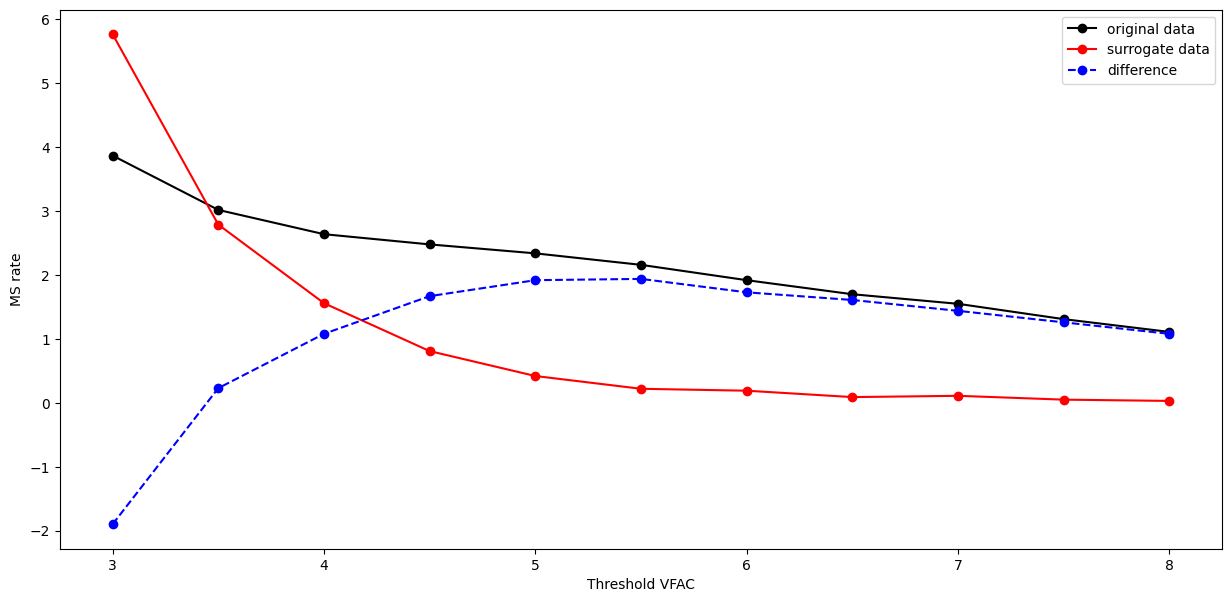

In [103]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(threshold_sum.vfc, threshold_sum.rate, marker='o', color="black", label="original data")
ax.plot(threshold_sum.vfc, threshold_sum.surrogate_rate, marker='o', color="red", label="surrogate data")
ax.plot(threshold_sum.vfc, threshold_sum.rate-threshold_sum.surrogate_rate, marker='o', linestyle='dashed', color="blue", label="difference")
ax.legend()
ax.set_xlabel("Threshold VFAC")
ax.set_ylabel("MS rate")